# Grid path planning with dynamics

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/grid_states.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This example uses a uniform grid for its roadmap, but extended over higher dimensions to include velocity states.

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [76]:
pos_step = 1.0
x_range = np.arange(0,10,pos_step)
y_range = np.arange(0,10,pos_step)

In [77]:
vmin = 1.0
vmax = 1.2
spd_range = np.linspace(vmin,vmax,3)
print(spd_range)

[1.  1.1 1.2]


In [78]:
num_angles = 12
hdg_range = np.arange(0,2*np.pi,2*np.pi/num_angles)
print(hdg_range)

[0.         0.52359878 1.04719755 1.57079633 2.0943951  2.61799388
 3.14159265 3.66519143 4.1887902  4.71238898 5.23598776 5.75958653]


In [79]:
grid_points = [(x,y,spd*np.cos(theta),spd*np.sin(theta)) for x in x_range for y in y_range for theta in hdg_range for spd in spd_range]
num_points = len(grid_points)
print(num_points)

3600


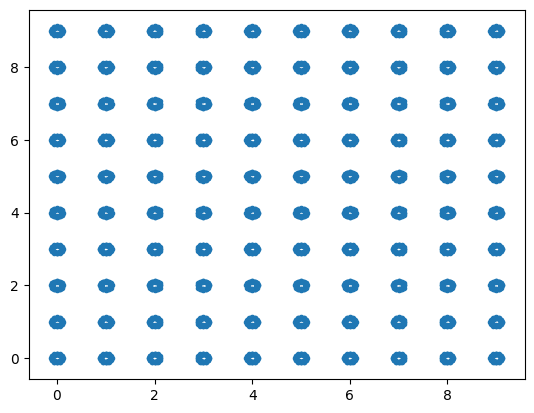

In [80]:
vel_scale = 0.1
plt.plot([p[0]+vel_scale*p[2] for p in grid_points],[p[1]+vel_scale*p[3] for p in grid_points],'.')

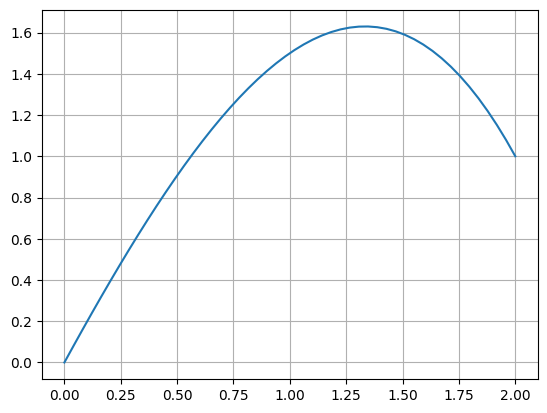

In [81]:
p0 = 0
v0 = 2
p1 = 1
v1 = -2

T = 2.0

def fit_cubic(p0,p1,v0,v1,T):
    a = p0
    b = T*v0
    c = 3*(p1-p0) - T*v1 - 2*T*v0
    d = T*v1 + T*v0 - 2*(p1-p0)
    return a,b,c,d

a,b,c,d = fit_cubic(p0,p1,v0,v1,T)

t = np.linspace(0,T,50)
s = t/T
p = a + b*s + c*(s**2) + d*(s**3)
plt.plot(t,p)
plt.grid('on')
plt.show()

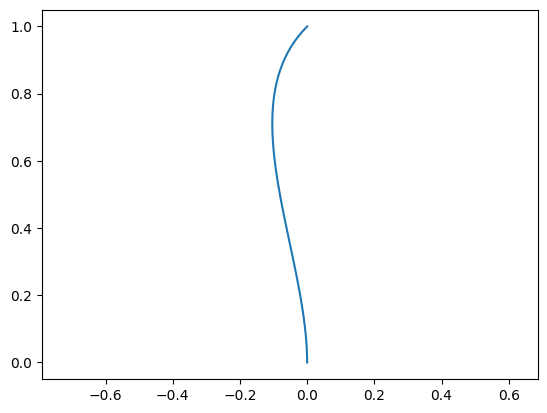

In [82]:
x1,y1,vx1,vy1 = 0,0,0,1
x2,y2,vx2,vy2 = 0,1,0.7,0.7

T = 1.0

ax,bx,cx,dx = fit_cubic(x1,x2,vx1,vx2,T)
ay,by,cy,dy = fit_cubic(y1,y2,vy1,vy2,T)

plt.plot(ax+bx*s+cx*s**2+dx*s**3,
         ay+by*s+cy*s**2+dy*s**3,'-')
plt.axis('equal')
plt.show()

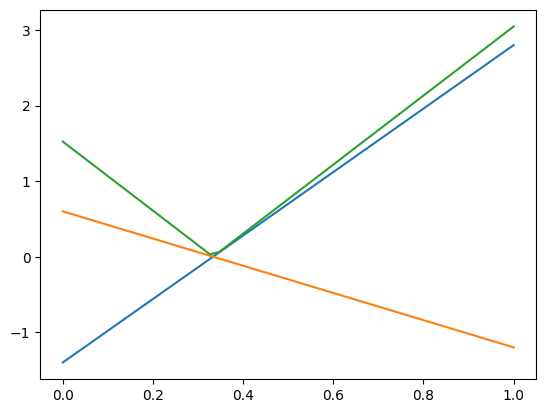

In [83]:
accx = (2*cx + 6*dx*s)/T**2
accy = (2*cy + 6*dy*s)/T**2
accm = np.sqrt(accx**2 + accy**2)
plt.plot(s,accx,s,accy,s,accm)

In [84]:
T = 0.1
acc_lim = 0.5

for ii in range(10):
    ax,bx,cx,dx = fit_cubic(x1,x2,vx1,vx2,T)
    ay,by,cy,dy = fit_cubic(y1,y2,vy1,vy2,T)
    acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
    acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
    acc_max = max(acc0,acc1)
    print(T,acc_max)
    if acc_max > acc_lim:
        T = T*2

T_low = 0.5*T
T_high = T

for ii in range(10):
    T = 0.5*(T_low+T_high)
    ax,bx,cx,dx = fit_cubic(x1,x2,vx1,vx2,T)
    ay,by,cy,dy = fit_cubic(y1,y2,vy1,vy2,T)
    acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
    acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
    acc_max = max(acc0,acc1)
    print(T,acc_max,T_low,T_high)
    if acc_max > acc_lim:
        T_low = T
    else:
        T_high = T
    


0.1 552.7096887155136
0.2 126.77539193392384
0.4 26.4433356443547
0.8 4.862162584694181
1.6 1.869000819288209
3.2 1.265359733003326
6.4 0.745410866314102
12.8 0.40292908395268034
12.8 0.40292908395268034
12.8 0.40292908395268034
9.600000000000001 0.5236447558174709 6.4 12.8
11.200000000000001 0.4554808362554454 9.600000000000001 12.8
10.400000000000002 0.48721049189045984 9.600000000000001 11.200000000000001
10.000000000000002 0.5047771785649586 9.600000000000001 10.400000000000002
10.200000000000003 0.4958396885184519 10.000000000000002 10.400000000000002
10.100000000000001 0.5002688844775006 10.000000000000002 10.200000000000003
10.150000000000002 0.49804452850301045 10.100000000000001 10.200000000000003
10.125000000000002 0.49915425100677013 10.100000000000001 10.150000000000002
10.1125 0.4997109518580794 10.100000000000001 10.125000000000002
10.106250000000001 0.49998976394417693 10.100000000000001 10.1125


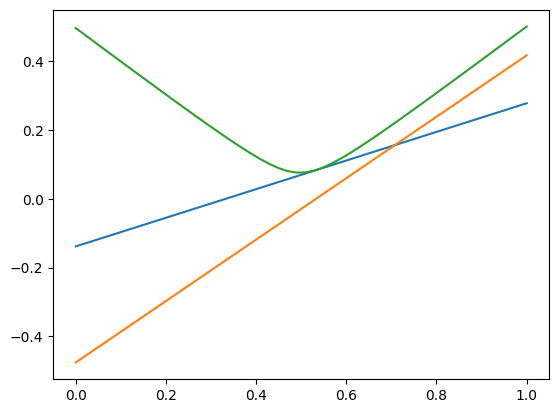

In [85]:
accx = (2*cx + 6*dx*s)/T**2
accy = (2*cy + 6*dy*s)/T**2
accm = np.sqrt(accx**2 + accy**2)
plt.plot(s,accx,s,accy,s,accm)

In [86]:
acc_lim = 1.5
dist_lim = 1.75*pos_step

def travel_time(s1,s2):
    x1,y1,vx1,vy1 = s1
    x2,y2,vx2,vy2 = s2
    if x1==x2 and y1==y2:
        return np.inf,[],[]
    if (x2-x1)**2 + (y2-y1)**2 > dist_lim**2:
        return np.inf,[],[]
    #if (x2-x1)*vx1 < 0.0:
    #    return np.inf,[],[]
    #if (y2-y1)*vy1 < 0.0:
    #    return np.inf,[],[]
    #if (x2-x1)*vx2 < 0.0:
    #    return np.inf,[],[]
    #if (y2-y1)*vy2 < 0.0:
    #    return np.inf,[],[]
    T = 1.0
    for ii in range(10):
        ax,bx,cx,dx = fit_cubic(x1,x2,vx1,vx2,T)
        ay,by,cy,dy = fit_cubic(y1,y2,vy1,vy2,T)
        acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
        acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
        acc_max = max(acc0,acc1)
        #print(T,acc_max)
        if acc_max > acc_lim:
            T = T*2
        else:
            break
    if T>=2:
        T_high = T
        T_low = T/2
        for ii in range(5):
            T = 0.5*(T_high+T_low)
        ax,bx,cx,dx = fit_cubic(x1,x2,vx1,vx2,T)
        ay,by,cy,dy = fit_cubic(y1,y2,vy1,vy2,T)
        acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
        acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
        acc_max = max(acc0,acc1)
        #print(T,acc_max)
        if acc_max > acc_lim:
            T_high = T
        else:
            T_low = T
    s = np.linspace(0,1,20)
    return T,ax+bx*s+cx*s**2+dx*s**3,ay+by*s+cy*s**2+dy*s**3


1.0


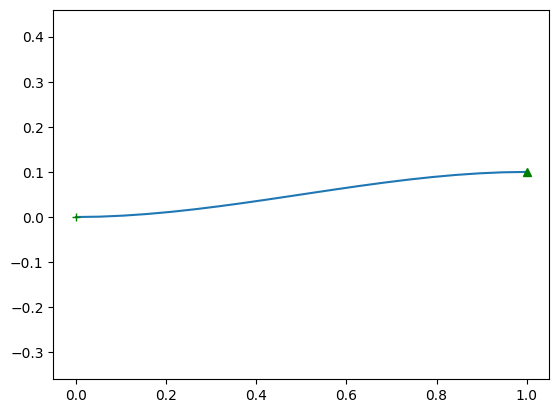

In [87]:
s1 = (0.0,0.0,1.0,0.0)
s2 = (1.0,0.1,1.0,0.0)
t,x,y = travel_time(s1,s2)
print(t)
plt.plot(x,y)
plt.plot(s1[0],s1[1],'g+')
plt.plot(s2[0],s2[1],'g^')
plt.axis('equal')
plt.show()

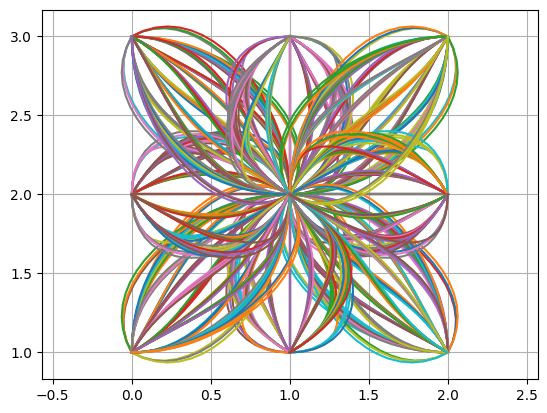

In [88]:
for (i1,s1) in enumerate(grid_points):
    if (s1[0],s1[1])!=(1.0,2.0):
        continue
    for (i2,s2) in enumerate(grid_points):
        t12,x,y = travel_time(s1,s2)
        if t12 < 3.0:
            plt.plot(x,y,'-')
plt.axis('equal')
plt.grid('on')
plt.show()

In [89]:
cost_matrix = np.inf*np.ones((num_points,num_points))
link_matrix = {}
for (i1,s1) in enumerate(grid_points):
    for (i2,s2) in enumerate(grid_points):
        t12,x,y = travel_time(s1,s2)
        if t12 < 3.0:
            cost_matrix[i1,i2] = t12
            link_matrix[(i1,i2)] = (x,y)

In [90]:
from scipy.sparse.csgraph import shortest_path
path_length,predecessors = shortest_path(cost_matrix, return_predecessors=True)

In [93]:
start_node = 120
target_node = 3300
print(grid_points[start_node])
print(grid_points[target_node])
print(path_length[start_node,target_node])

(0.0, 3.0, -0.4999999999999998, 0.8660254037844387)
(9.0, 1.0, -0.5000000000000004, -0.8660254037844385)
11.0


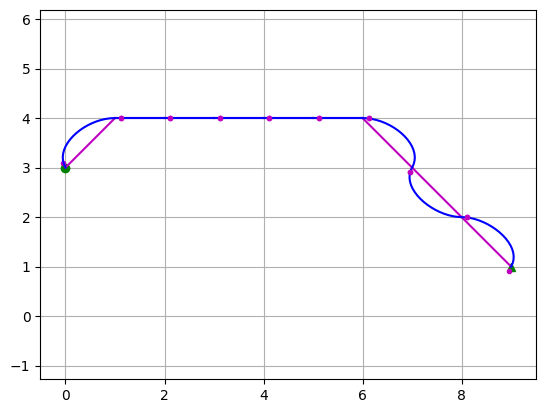

In [94]:
plt.plot([grid_points[start_node][0]],
         [grid_points[start_node][1]],'go')
plt.plot([grid_points[target_node][0]],
         [grid_points[target_node][1]],'g^')
curr_node = target_node
for kk in range(len(grid_points)):
    prev_node = predecessors[start_node,curr_node]
    plt.plot([grid_points[curr_node][0] + vel_scale*grid_points[curr_node][2],
              grid_points[prev_node][0] + vel_scale*grid_points[prev_node][2]],
             [grid_points[curr_node][1] + vel_scale*grid_points[curr_node][3],
              grid_points[prev_node][1] + vel_scale*grid_points[prev_node][3]],'m.')
    plt.plot([grid_points[curr_node][0],
              grid_points[prev_node][0]],
             [grid_points[curr_node][1],
              grid_points[prev_node][1]],'m-')
    px,py = link_matrix[(prev_node,curr_node)]
    plt.plot(px,py,'b-')
    curr_node=prev_node
    if curr_node==start_node:
        break
plt.grid('on')
plt.axis('equal')
plt.show()